In [47]:
using ReactionMechanismSimulator
using PyPlot
using DifferentialEquations
using Sundials
using SciMLBase
using QuadGK

In [48]:
outdict = readinput("Ag_C2_042925.rms")

[15:57:28] WARNING: not removing hydrogen atom without neighbors
[15:57:28] WARNING: not removing hydrogen atom without neighbors
┌ Warning: failed to generate StokesDiffusivity model for species vacantX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CHO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2HX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species OCX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.j

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [49]:
boundarylayerspcs = outdict["gas"]["Species"]
boundarylayerrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [50]:
sitedensity = 2.943e-5; # Cu111 site density is 2.943e-9 mol/cm^2 or 2.943e-5 mol/m^2
boundarylayer = IdealDiluteSolution(boundarylayerspcs,boundarylayerrxns,solv,name="boundarylayeruid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [51]:
# Reservoir is a 100 mL (100e-6 m^3) cell
# Proton concentration is 10^-7 mol/L (10^-4 mol/m^3)
# CO2 concentration is 0.01 mol/L (10 mol/m^3), saturation solubility ~0.03 mol/L
# AVratio in experiments is 36 m^-1 but is measured by surface area/reservoir volume
# Area of the electrode is therefore 3.6e1 m^-1 * 1e2 * 1e-6 m^3 = 3.6e-3 m^2 = 36 cm^2
# Assume boundary layer thickness d_bl = 1 mm or 1e-3 m
# Volume of the boundary layer V_bl = 3.6e-3 m^2 * 1e-3 m = 3.6e-6 m^3
# Actual AVratio is therefore 3.6e-3 m^2 / 3.6e-6 m^3 = 1e3 m^-1 (reciprocal of d_bl)
# Amount of sites is 2.943e-5 mol/m^2 * 3.6e-3 m^2 = 10.595e-8 mol

C_proton = 1e-7*1e3;
C_co2 = 1e-2*1e3;
C_default = 1e-12;
V_res = 1e3;
layer_thickness = 1e-3;
A_surf = V_res*36;
V_bl = V_res;
sites = sitedensity*A_surf;

# The initial conditions for individual species are moles not concentration, so we need to multiply concentration by boundary layer volume
initialcondsboundarylayer = Dict(["proton"=>C_proton*V_bl,
                                  "CO2"=>C_co2*V_bl,
                                  "H2"=>C_default*10*V_bl,
                                  "O=CO"=>C_default*V_bl,
                                  "V"=>V_bl,"T"=>300,"Phi"=>0.0,"d"=>0.0]);
initialcondsreservoir = Dict(["proton"=>C_proton,
                              "CO2"=>C_co2,
                              "V"=>V_res,"T"=>300]);


# Assume voltage is -1.0 V vs. R.H.E. which equates to -1.414 V vs. S.H.E. at pH=7
initialcondssurf = Dict(["CO2X"=>0.4*sites,
        "CHO2X"=>0.1*sites,
        "CO2HX"=>0.1*sites,
        "OX"=>0.1*sites,
        "OCX"=>0.1*sites,
        "vacantX"=>0.1*sites,
        "CH2O2X"=>0.05*sites,
        "CHOX"=>0.04*sites,
        "CH2OX"=>0.01*sites,
        "A"=>A_surf,"T"=>300,"Phi"=>-1.414]);

In [52]:
domainboundarylayer, y0boundarylayer, pboundarylayer = ConstantTVDomain(phase=boundarylayer, initialconds=initialcondsboundarylayer);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [53]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainboundarylayer,
  domaincat,interfacerxns,298.15,A_surf);

In [54]:
# start with 1mm layer thickness
diffusionlayer = ConstantReservoirDiffusion(domainboundarylayer, initialcondsreservoir, A_surf, layer_thickness);

In [55]:
interfaces = [inter, diffusionlayer];

In [56]:
@time react,y0,p = Reactor((domainboundarylayer,domaincat), (y0boundarylayer,y0cat), (0.0, 1e3), interfaces, (pboundarylayer,pcat,pinter));

  0.005119 seconds (9.04 k allocations: 8.120 MiB)


In [57]:
@time sol = solve(react.ode,Sundials.CVODE_BDF(),abstol=1e-22,reltol=1e-8);

  0.655995 seconds (1.28 M allocations: 681.600 MiB, 15.24% gc time)


In [58]:
sol.t[end]

1000.0

In [59]:
sol.retcode

ReturnCode.Success = 1

In [60]:
ssys = SystemSimulation(sol,(domainboundarylayer,domaincat,), interfaces,p);

In [61]:
concentrations(ssys.sims[1], 1e3)

25-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
 10.0
  9.999999999999999e-5
  0.0
  0.0
  9.621911951804017e-13
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [62]:
"""
diffusive flux to the reservoir
"""
function flux_to_reservoir(sim,t,reservoirinterface)
    cs = concentrations(sim,t)
    println(reservoirinterface.A);
    println(reservoirinterface.layer_thickness);
    println(sim.domain.diffusivity);
    println(cs);
    println(reservoirinterface.c);
    return reservoirinterface.A .* sim.domain.diffusivity .* (cs - reservoirinterface.c) / reservoirinterface.layer_thickness
end

"""
Integrates the flux to the reservoir and computes the concentration assuming
there is no prior concentration of that species in the reservoir
"""
function get_reservoir_concentration(sim,t,reservoirinterface,Vres)
    intg,err = quadgk(x -> flux_to_reservoir(sim,x,reservoirinterface), 0, t);
    return intg./Vres
end

get_reservoir_concentration

In [63]:
# Logarithmic time scale
t_vals = 10 .^ range(-12, stop=3, length=100);

# Compute reservoir concentrations
flux_vals = [flux_to_reservoir(ssys.sims[1], t, diffusionlayer) for t in t_vals]
# conc_vals = [get_reservoir_concentration(ssys.sims[1], t, diffusionlayer, V_res) for t in t_vals]
conc_vals_bl = [concentrations(ssys.sims[1], t) for t in t_vals]
flux_matrix = hcat(flux_vals...);
# conc_matrix = hcat(conc_vals...);
conc_matrix_bl = hcat(conc_vals_bl...);


36000.0
0.001
[1.2791698254820209e-9, 1.8057956542205799e-9, 1.6715781069123858e-9, 1.2139156476242518e-9, 1.122671285175347e-9, 1.6586845884779859e-9, 1.6586845884779859e-9, 1.14440221020022e-9, 1.0706139020926982e-9, 1.2950488917250014e-9, 1.0161703941206926e-9, 1.3343544679270026e-9, 1.2139156476242518e-9, 1.0306102200591467e-9, 9.803948080706342e-10, 1.5410849742783295e-9, 9.803948080706342e-10, 9.491783447442542e-10, 9.491783447442542e-10, 9.491783447442542e-10, 1.0884930230558902e-9, 9.928695644331783e-10, 1.0270398396914194e-9, 9.215925647738548e-10, 1.0459074498676583e-9]
[0.0, 0.0, 0.0, 0.0, 9.999999999999998, 9.999999999999999e-5, 0.0, 0.0, 1.0e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0000000000000001e-11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 10.0, 9.999999999999999e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
36000.0
0.001
[1.2791698254820209e-9, 1.8057956542205799e-9, 1.6715781069123858e-9, 1.213

In [ ]:
# clf()

# for i in 1:size(conc_matrix, 1)
#     if maximum(conc_matrix[i, :]) > 1e-12
#         plot(t_vals, conc_matrix[i, :], label=ssys.sims[1].domain.phase.species[i].name)

#     end
# end

# xscale("log")
# yscale("log")
# xlabel("Time (s)")
# ylabel("Reservoir Concentration")
# legend()
# tight_layout()
# gcf()

UndefVarError: UndefVarError: `conc_matrix` not defined

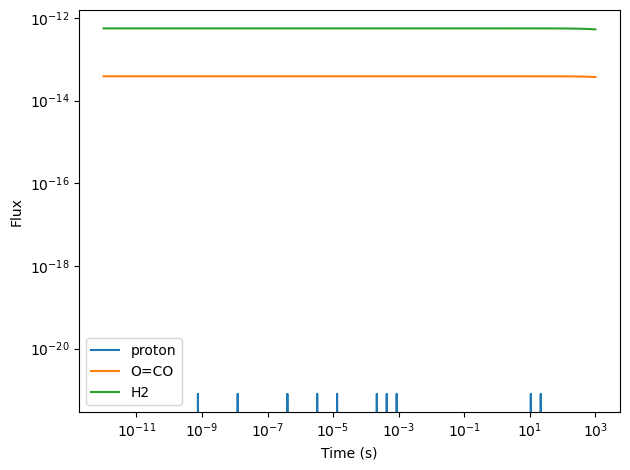

In [89]:
clf()

for i in 1:size(flux_matrix, 1)
    if maximum(flux_matrix[i, :]) > 1e-25
        plot(t_vals, flux_matrix[i, :], label=ssys.sims[1].domain.phase.species[i].name)

    end
end

xscale("log")
yscale("log")
xlabel("Time (s)")
ylabel("Flux")
legend()
tight_layout()
gcf()

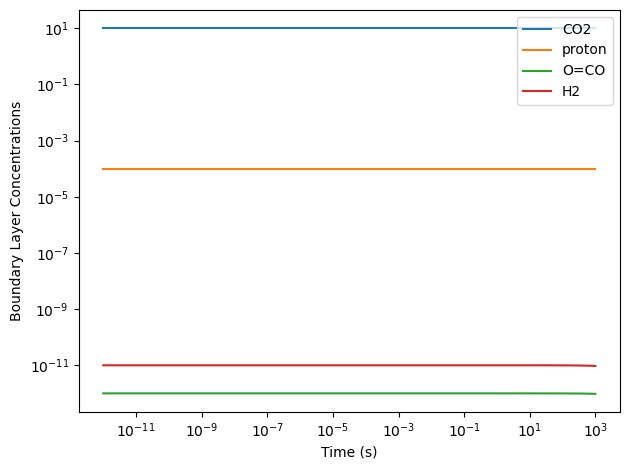

In [66]:
clf()
for i in 1:size(conc_matrix_bl, 1)
    if maximum(conc_matrix_bl[i, :]) > 1e-25
        plot(t_vals, conc_matrix_bl[i, :], label=ssys.sims[1].domain.phase.species[i].name)

    end
end

xscale("log")
yscale("log")
xlabel("Time (s)")
ylabel("Boundary Layer Concentrations")
legend()
tight_layout()
gcf()

In [67]:
flux_to_reservoir(ssys.sims[1],1e-12,diffusionlayer)

36000.0
0.001
[1.2791698254820209e-9, 1.8057956542205799e-9, 1.6715781069123858e-9, 1.2139156476242518e-9, 1.122671285175347e-9, 1.6586845884779859e-9, 1.6586845884779859e-9, 1.14440221020022e-9, 1.0706139020926982e-9, 1.2950488917250014e-9, 1.0161703941206926e-9, 1.3343544679270026e-9, 1.2139156476242518e-9, 1.0306102200591467e-9, 9.803948080706342e-10, 1.5410849742783295e-9, 9.803948080706342e-10, 9.491783447442542e-10, 9.491783447442542e-10, 9.491783447442542e-10, 1.0884930230558902e-9, 9.928695644331783e-10, 1.0270398396914194e-9, 9.215925647738548e-10, 1.0459074498676583e-9]
[0.0, 0.0, 0.0, 0.0, 10.0, 9.999999999999999e-5, 0.0, 0.0, 1.0e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0000000000000001e-11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 10.0, 9.999999999999999e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 3.854210047533713e-14
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [68]:
res_cs = get_reservoir_concentration(ssys.sims[1],1e3,diffusionlayer,V_res)

36000.0
0.001
[1.2791698254820209e-9, 1.8057956542205799e-9, 1.6715781069123858e-9, 1.2139156476242518e-9, 1.122671285175347e-9, 1.6586845884779859e-9, 1.6586845884779859e-9, 1.14440221020022e-9, 1.0706139020926982e-9, 1.2950488917250014e-9, 1.0161703941206926e-9, 1.3343544679270026e-9, 1.2139156476242518e-9, 1.0306102200591467e-9, 9.803948080706342e-10, 1.5410849742783295e-9, 9.803948080706342e-10, 9.491783447442542e-10, 9.491783447442542e-10, 9.491783447442542e-10, 1.0884930230558902e-9, 9.928695644331783e-10, 1.0270398396914194e-9, 9.215925647738548e-10, 1.0459074498676583e-9]
[0.0, 0.0, 0.0, 0.0, 10.0, 9.999999999999999e-5, 0.0, 0.0, 9.809134493830187e-13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.726416782380489e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 10.0, 9.999999999999999e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
36000.0
0.001
[1.2791698254820209e-9, 1.8057956542205799e-9, 1.6715781069123858e-9, 1.213

25-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
 -2.5528866545177183e-23
  0.0
  0.0
  3.780880481959538e-14
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [69]:
sort(res_cs)

25-element Vector{Float64}:
 -2.5528866545177183e-23
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  3.780880481959538e-14
  5.396816575437587e-13

In [70]:
getfield.(ssys.sims[1].domain.phase.species,:name)

25-element Vector{String}:
 "Ar"
 "He"
 "Ne"
 "N2"
 "CO2"
 "proton"
 "H"
 "C=O"
 "O=CO"
 "O2"
 ⋮
 "O=CC=O"
 "O=CCO"
 "COC=O"
 "CC(=O)O"
 "CO-2"
 "CC=O"
 "OCO"
 "OCCO"
 "C=C"

In [71]:
getfield.(ssys.sims[2].domain.phase.species,:name)

76-element Vector{String}:
 "vacantX"
 "CO2X"
 "CHO2X"
 "CO2HX"
 "OCX"
 "OX"
 "CH2O2X"
 "CHOX"
 "CH2OX"
 "HOX"
 ⋮
 "CC#[Pt]"
 "[Pt]C#CO[Pt]"
 "[Pt]OC#CO[Pt]"
 "COC=O.[Pt]"
 "O=COC[Pt]"
 "O=COC=[Pt]"
 "O=COC#[Pt]"
 "[Pt]C=C=[Pt]"
 "[Pt]=CC=[Pt]"

In [72]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [73]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

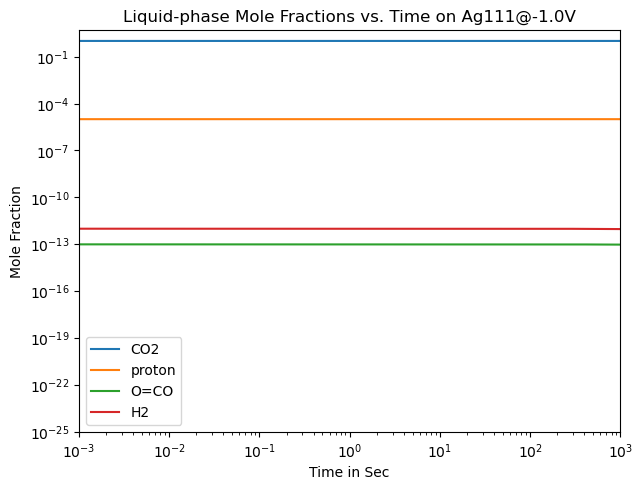

In [74]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-25, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-3, 1e3)
ylim(1e-25, 5)
title("Liquid-phase Mole Fractions vs. Time on Ag111@-1.0V")
gcf()

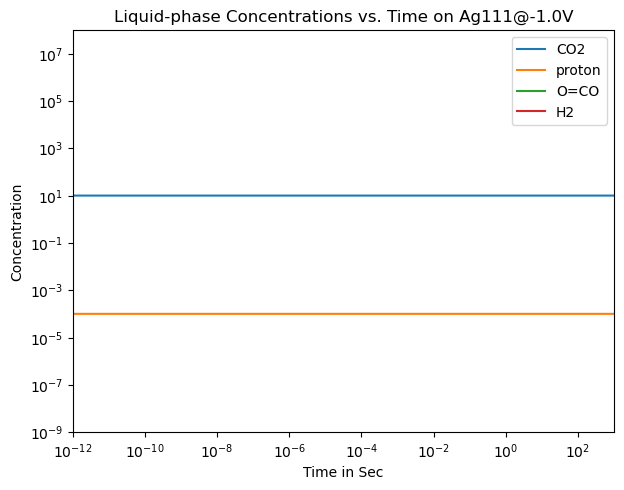

In [75]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1e-25, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-9, 1e8)
title("Liquid-phase Concentrations vs. Time on Ag111@-1.0V")
gcf()

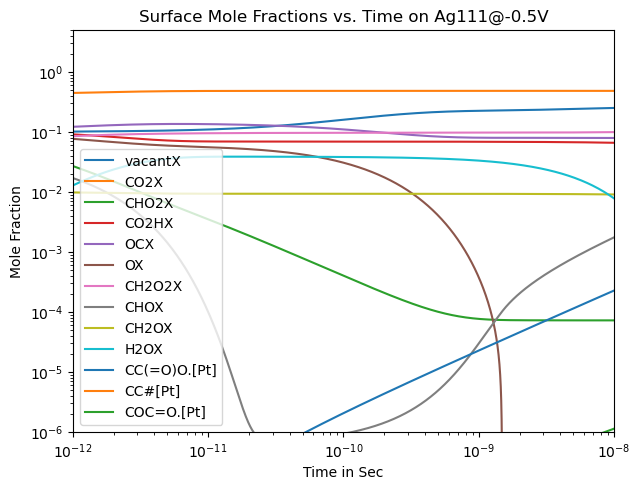

In [76]:
exclude_species = ["H2O"]
plotX(ssys.sims[2], 1e-2, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e-8)
ylim(1e-6, 5)
title("Surface Mole Fractions vs. Time on Ag111@-0.5V")
gcf()

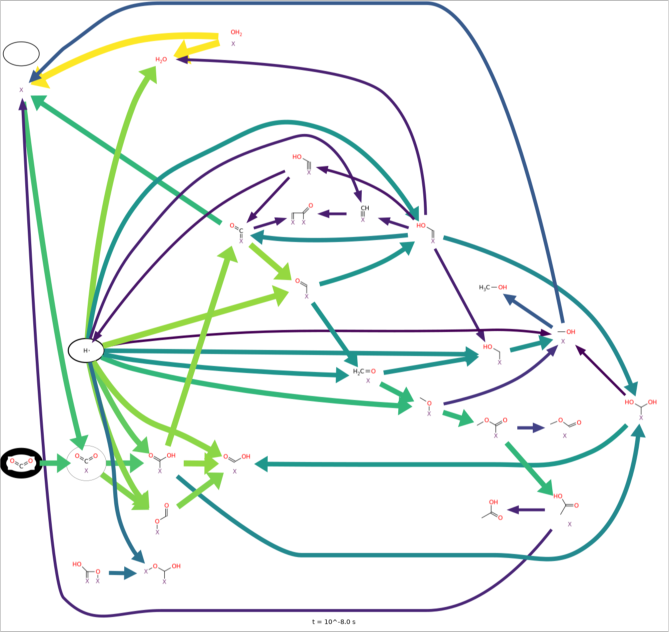

In [77]:
getfluxdiagram(ssys,1e-8;speciesratetolerance=1e-8)

In [78]:
function plotROP(ssys,name,t;N=0,tol=0.01)
    clf()
    rop = rops(ssys, name, t)
    inds = rop.nzind[reverse(sortperm(abs.(rop.nzval)))]
    if N == 0
        N = length(inds)
    elseif N > length(inds)
        N = length(inds)
    end
    inds = inds[1:N]
    mval = abs(rop[inds[1]])
    minval = mval*tol
    k = 1
    while k < length(inds) && abs(rop[inds[k]]) >= minval
        k += 1
    end
    inds = inds[1:k]
    net_rops = sum(rop[inds])
    println("Net ROPs for species $name is: $net_rops")

    for (i, j) in enumerate(inds)
        println("Showing the reaction with $i th highest ROP for species $name:")
        println(getrxnstr(ssys.reactions[j]))
        println("ROP = ", rop[inds[i]])
        println(ssys.reactions[j].kinetics)
    end

    xs = Array{Float64,1}(1:length(inds))
    barh(xs,reverse(rop[inds]))
    yticks(xs,reverse(getrxnstr.(ssys.reactions[inds])))
    xlabel("Production/Loss Rate mol/s")
    gcf()
end

plotROP (generic function with 1 method)

In [79]:
function PrintKinDetail(inter, speciesname)
    println("Showing Kinetics details for reactions involving species $speciesname\n")
    for (i,rxn) in enumerate(inter.reactions)
        flag = false
        for j = 1:length(rxn.reactants)
            if rxn.reactants[j].name == speciesname
                flag = true
            end
        end
        for j = 1:length(rxn.products)
            if rxn.products[j].name == speciesname
                flag = true
            end
        end
        if flag
            println(getrxnstr(rxn))
            println(rxn.kinetics)
            kf = inter.kfs[i]
            krev = inter.krevs[i]
            kc = kf/krev
            println("kf = $kf")
            println("krev = $krev")
            println("Kc = $kc\n")
        end
    end
end

PrintKinDetail (generic function with 1 method)

Net ROPs for species H2 is: 4.150043944948913e-6
Showing the reaction with 1 th highest ROP for species H2:
vacantX+H2<=>[H][H].[Pt]
ROP = 4.150043944066419e-6
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 6964.172772895365
  n: Float64 0.4999999999999679
  Ea: Float64 10385.942601610406
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species H2:
vacantX+vacantX+H2<=>HX+HX
ROP = 8.824942940831307e-16
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 1.3606521727535222e9
  n: Float64 0.500000000000007
  Ea: Float64 88008.54855905028
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species H2:
H2+CX<=>CH2X
ROP = -4.601988923484231e-31
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 34820.86386446816
  n: Float64 0.4999999999999999
  Ea: Float64 29700.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()



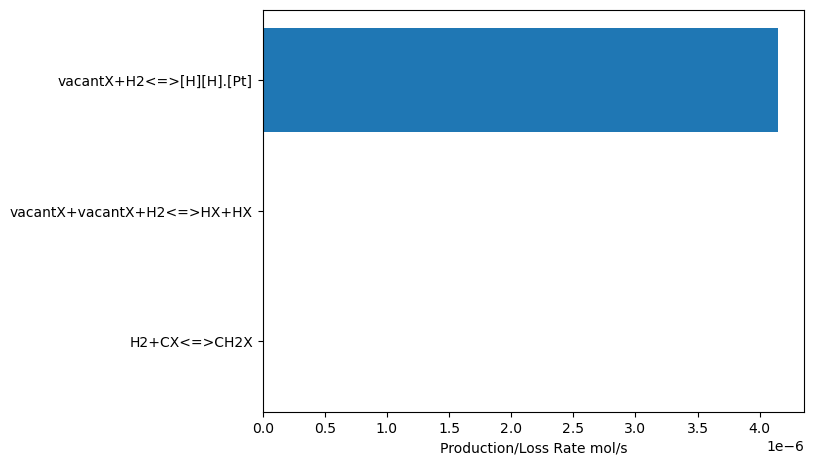

In [80]:
plotROP(ssys, "H2",1;N=15,tol=0.0)

Net ROPs for species O=CO is: 5.604305953495311
Showing the reaction with 1 th highest ROP for species O=CO:
vacantX+O=CO<=>CH2O2X
ROP = 5.6043056265563305
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 18219.141768086323
  n: Float64 0.49999999999994343
  Ea: Float64 3.5152448274688953e-10
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species O=CO:
proton+O=COC[Pt]<=>CH2X+O=CO
ROP = 3.2326678624418197e-7
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 64651.660819360055
  q: Float64 0.25
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species O=CO:
HX+O=CO<=>OC(O)[Pt]
ROP = 2.545102245298824e-9
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 9109.570884041126
  n: Float64 0.49999999999997213
  Ea: Float64 73060.00000000017
  unc: EmptyRa

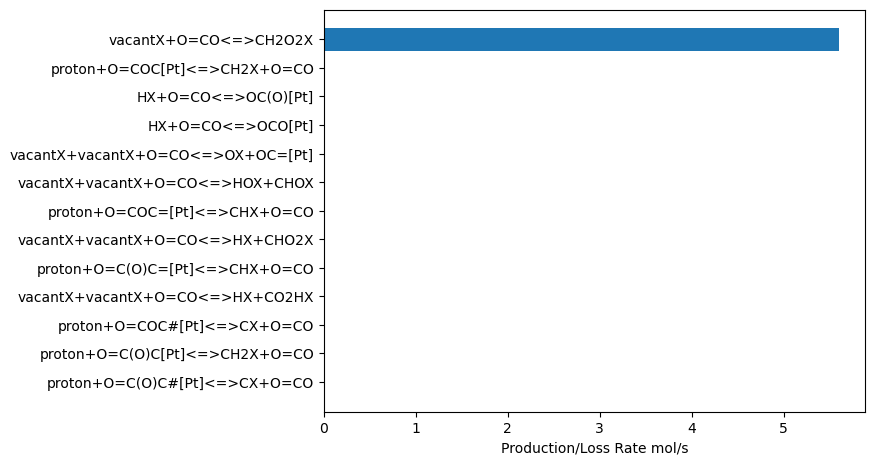

In [81]:
plotROP(ssys, "O=CO",1;N=15,tol=0.0)

Net ROPs for species CH2O2X is: 256113.64597034414
Showing the reaction with 1 th highest ROP for species CH2O2X:
proton+CO2HX<=>CH2O2X
ROP = 174960.7504236172
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 48898.20910952611
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species CH2O2X:
CHO2X+CHO2X<=>CO2X+CH2O2X
ROP = 68846.4434592838
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 4.18e17
  n: Float64 0.0
  Ea: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species CH2O2X:
CO2HX+OC(O)[Pt]<=>CH2O2X+CH2O2X
ROP = 4912.978701228226
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 8.36e17
  n: Float64 0.0
  Ea: Float64 10760.85577299056
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 4

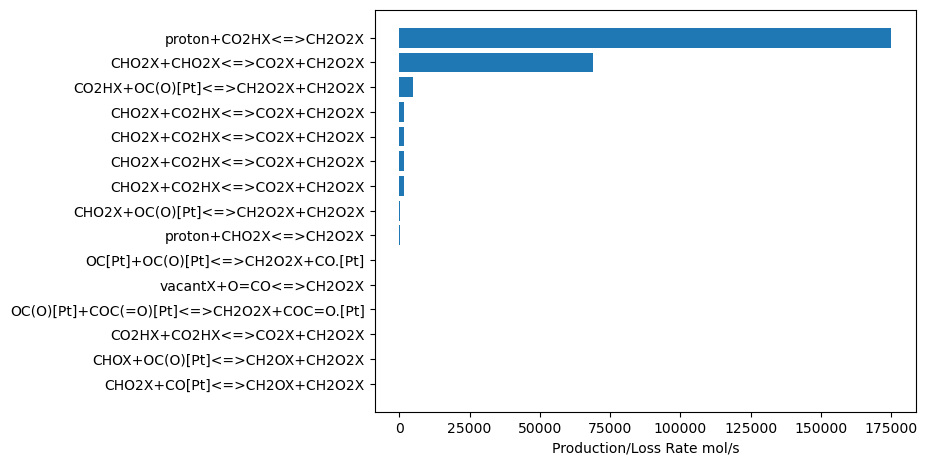

In [82]:
plotROP(ssys,"CH2O2X",1e-8;N=15,tol=0.0)

Net ROPs for species CHO2X is: 0.04766471053749799
Showing the reaction with 1 th highest ROP for species CHO2X:
proton+CO2X<=>CHO2X
ROP = 7.33153345091504
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e14
  n: Float64 0.0
  Ea: Float64 62276.629849940306
  q: Float64 0.25
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species CHO2X:
CHO2X+CHO2X<=>CO2X+CH2O2X
ROP = -5.100049516714395
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 4.18e17
  n: Float64 0.0
  Ea: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species CHO2X:
proton+CHO2X<=>CH2O2X
ROP = -1.1715890842651724
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 3012.3559299445205
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRa

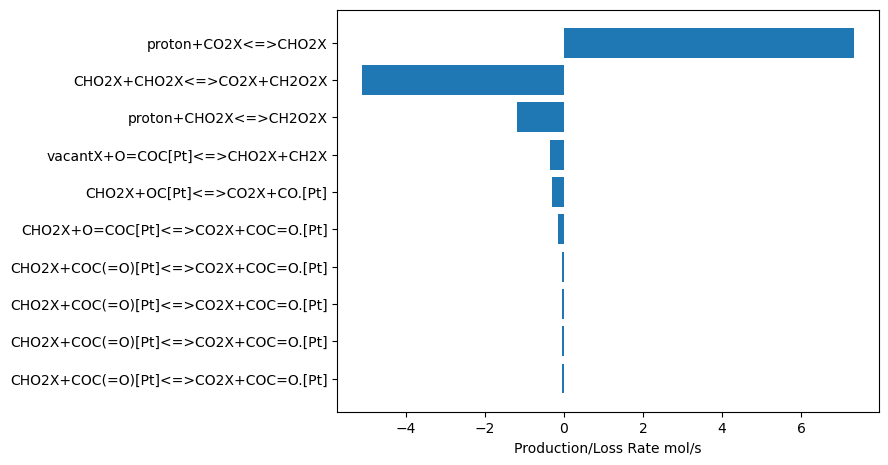

In [83]:
plotROP(ssys,"CHO2X",1;N=10,tol=0.0)

Net ROPs for species CO2HX is: 0.0003287112625315043
Showing the reaction with 1 th highest ROP for species CO2HX:
proton+CO2X<=>CO2HX
ROP = 3.6983360301770674
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 75249.98822394571
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species CO2HX:
proton+CO2HX<=>H2O+OCX
ROP = -1.763416912648506
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 22584.872508307497
  q: Float64 0.25
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species CO2HX:
proton+CO2HX<=>CH2O2X
ROP = -1.763416912648506
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 48898.20910952611
  q:

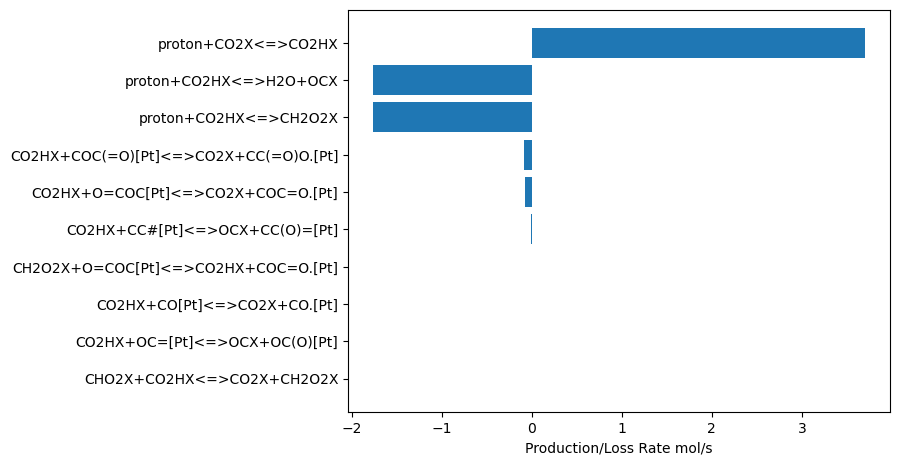

In [84]:
plotROP(ssys,"CO2HX",1;N=10,tol=0.0)

Net ROPs for species OX is: 1.4136089039327533e-11
Showing the reaction with 1 th highest ROP for species OX:
CC(=[Pt])O[Pt]<=>OX+CC#[Pt]
ROP = -1.7128016290872063e-5
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 4.22e12
  n: Float64 0.0
  Ea: Float64 120221.54975291854
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species OX:
OCX+CO[Pt]<=>OX+CC(=O)[Pt]
ROP = 1.4499893130450164e-5
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 1.39e17
  n: Float64 0.101
  Ea: Float64 19000.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species OX:
proton+[Pt]CO[Pt]<=>OX+CH3X
ROP = 1.8809220248911023e-6
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 33158.775324534305
  q: Float64 0.25
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the r

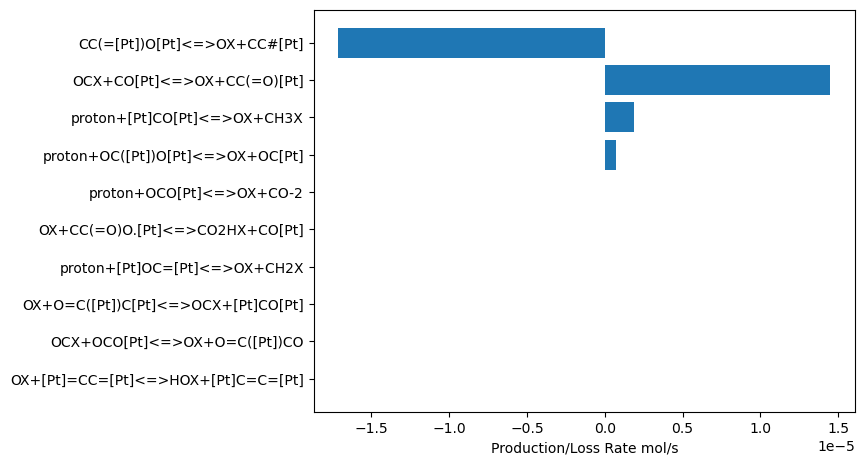

In [85]:
plotROP(ssys,"OX",1;N=10,tol=0.0)

Net ROPs for species OCX is: -25790.517609215578
Showing the reaction with 1 th highest ROP for species OCX:
vacantX+COC(=O)[Pt]<=>OCX+CO[Pt]
ROP = -33414.000691836336
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 1.46e20
  n: Float64 -0.213
  Ea: Float64 108408.38075667131
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species OCX:
CO2HX+OC=[Pt]<=>OCX+OC(O)[Pt]
ROP = 16917.533367481974
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 1.39e17
  n: Float64 0.101
  Ea: Float64 19000.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species OCX:
proton+OCX<=>CHOX
ROP = -14539.798882979558
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 34575.95926752735
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction 

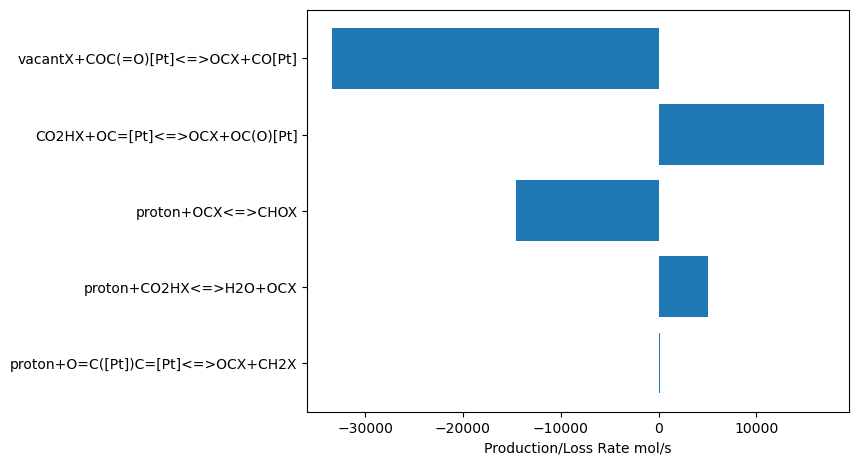

In [86]:
plotROP(ssys,"OCX",1.0e-6)

In [87]:
rops(ssys, "CH2O2X", 1e-12)

1507-element SparseArrays.SparseVector{Float64, Int64} with 160 stored entries:
  [4   ]  =  9.55649e9
  [5   ]  =  8.73256e5
  [6   ]  =  8.73256e5
  [7   ]  =  0.525013
  [10  ]  =  8.73256e5
  [11  ]  =  8.73256e5
  [13  ]  =  8.97035
          ⋮
  [1236]  =  1.8537e-55
  [1277]  =  7.77687e-21
  [1278]  =  1.22563e-31
  [1320]  =  71722.0
  [1321]  =  2.41674e5
  [1329]  =  -2.08598
  [1427]  =  -3.92132e-7
  [1465]  =  -0.00124323

In [88]:
rops(ssys, "O=CO", 1e-12)

1507-element SparseArrays.SparseVector{Float64, Int64} with 13 stored entries:
  [1329]  =  2.08598
  [1330]  =  2910.05
  [1334]  =  1.48575e-15
  [1335]  =  1.54698e-19
  [1382]  =  4.1262
  [1429]  =  3.54094e-15
  [1466]  =  1.67066e-10
  [1476]  =  8.20024e-34
  [1480]  =  1.44649e-31
  [1482]  =  -3.5696e-52
  [1495]  =  2.31879e-19
  [1498]  =  7.94182e-28
  [1500]  =  1.1583e-35